In [1]:
from zhinst.qcodes import ZISession
session = ZISession("192.168.0.220")

In [2]:
device = session.connect_device("DEV30577")

In [9]:
v_complex = mfli.demods[0].sample()  # 回傳 x + i·y (單位 Vrms)
print(v_complex)

{'timestamp': array([12851365635866], dtype=uint64), 'x': array([0.00713927]), 'y': array([0.00073848]), 'frequency': array([16.99999991]), 'phase': array([2.69328677]), 'dio': array([0], dtype=uint32), 'trigger': array([768], dtype=uint32), 'auxin0': array([0.00033073]), 'auxin1': array([-0.00165385])}


In [4]:
OUT_CHANNEL = 0
OUT_MIXER_CHANNEL = 1 # UHFLI: 3, HF2LI: 6, MFLI: 1
IN_CHANNEL = 0
DEMOD_INDEX = 0
OSC_INDEX = 0

with device.set_transaction():
    device.sigins[IN_CHANNEL].ac(0)
    device.sigins[IN_CHANNEL].range(0.2)

    device.demods[DEMOD_INDEX].enable(True)
    device.demods[DEMOD_INDEX].rate(10e3)
    device.demods[DEMOD_INDEX].adcselect(IN_CHANNEL)
    device.demods[DEMOD_INDEX].order(4)
    device.demods[DEMOD_INDEX].timeconstant(0.01)
    device.demods[DEMOD_INDEX].oscselect(OSC_INDEX)
    device.demods[DEMOD_INDEX].harmonic(1)

    device.sigouts[OUT_CHANNEL].on(True)
    device.sigouts[OUT_CHANNEL].enables[OUT_MIXER_CHANNEL].value(1)
    device.sigouts[OUT_CHANNEL].range(1)

In [5]:
LOOPCOUNT = 2

sweeper = session.modules.sweeper
sweeper.device(device)

sweeper.gridnode(device.oscs[OSC_INDEX].freq)
sweeper.start(1e3)
sweeper.stop(100e3)
sweeper.samplecount(100)
sweeper.xmapping(1)
sweeper.bandwidthcontrol(2)
sweeper.bandwidthoverlap(0)
sweeper.scan(0)
sweeper.loopcount(LOOPCOUNT)
sweeper.settling.time(0)
sweeper.settling.inaccuracy(0.001)
sweeper.averaging.tc(10)
sweeper.averaging.sample(10)

In [6]:
sample_node = device.demods[DEMOD_INDEX].sample
sweeper.subscribe(sample_node)

In [7]:
sweeper.save.fileformat.node_info.options

{0: _option_info(enum='mat', description='MATLAB'),
 1: _option_info(enum='csv', description='CSV'),
 2: _option_info(enum='zview', description='ZView (Impedance data only)'),
 3: _option_info(enum='sxm', description='SXM (Image format)'),
 4: _option_info(enum='hdf5', description='HDF5')}

In [8]:
sweeper.save.filename('sweep_with_save')
sweeper.save.fileformat('hdf5')

In [9]:
import logging
import sys

handler = logging.StreamHandler(sys.stdout)
logging.getLogger("zhinst.toolkit").setLevel(logging.INFO)
logging.getLogger("zhinst.toolkit").addHandler(handler)

In [10]:
sweeper.execute()
print(f"Perform {LOOPCOUNT} sweeps")
sweeper.wait_done(timeout=300)

Perform 2 sweeps
Progress: 0.0%
Progress: 5.0%
Progress: 11.0%
Progress: 19.0%
Progress: 31.0%
Progress: 45.0%
Progress: 61.0%
Progress: 80.0%
Progress: 99.0%
Progress: 5.0%
Progress: 11.0%
Progress: 20.0%
Progress: 30.0%
Progress: 45.0%
Progress: 61.0%
Progress: 83.0%
Progress: 100.0%


In [11]:
sweeper.save.save(True)
# Wait until the save is complete. The saving is done asynchronously in the background
# so we need to wait until it is complete. In the case of the sweeper it is important
# to wait for completion before before performing the module read command. The sweeper has
# a special fast read command which could otherwise be executed before the saving has
# started.
sweeper.save.save.wait_for_state_change(True, invert=True, timeout=5)

In [12]:
sweeper.unsubscribe(sample_node)
data = sweeper.read()

In [13]:
num_sweeps = len(data[sample_node])
assert num_sweeps == LOOPCOUNT, (
    f"The sweeper returned an unexpected number of sweeps: "
    f"{num_sweeps}. Expected: {LOOPCOUNT}."
)

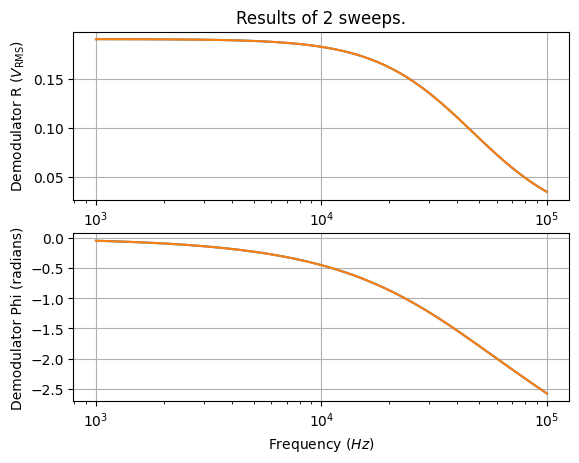

In [14]:
import matplotlib.pyplot as plt
import numpy as np

node_samples = data[sample_node]

_, (ax1, ax2) = plt.subplots(2, 1)
for sample in node_samples:
    frequency = sample[0]["frequency"]
    demod_r = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
    phi = np.angle(sample[0]["x"] + 1j * sample[0]["y"])
    ax1.plot(frequency, demod_r)
    ax2.plot(frequency, phi)
ax1.set_title(f"Results of {len(node_samples)} sweeps.")
ax1.grid()
ax1.set_ylabel(r"Demodulator R ($V_\mathrm{RMS}$)")
ax1.set_xscale("log")
ax2.autoscale()

ax2.grid()
ax2.set_xlabel("Frequency ($Hz$)")
ax2.set_ylabel(r"Demodulator Phi (radians)")
ax2.set_xscale("log")
ax2.autoscale()

plt.draw()
plt.show()

# 20250703

In [1]:
import time
from zhinst.qcodes import MFLI 
import numpy as np
import matplotlib.pyplot as plt

DEVICE_ID   = "DEV30577"    # Device serial number
SERVER_HOST = "192.168.0.220"  # instrument IP

mfli = MFLI(
    name      = "mfli",
    serial    = DEVICE_ID,
    host      = SERVER_HOST,
    interface = "pcie",    
)

In [10]:
def basic_mfli_setup(mfli, V_exc, frequency):
    OUT_CH   = 0  
    OSC      = 0   
    DEMOD    = 0  # demodulator 1 

    with mfli.set_transaction():
        # Output setup             
        mfli.sigouts[OUT_CH].on(True)
        
        mfli.sigouts[OUT_CH].enables[1].value(True)

        # Set output amplitudes for both paths
        mfli.sigouts[OUT_CH].amplitudes[1].value(V_exc)    
        
        # Set frequency of oscillator
        mfli.oscs[OSC].freq(frequency)  # Set frequency
        
        # Input setup
        mfli.sigins[0].range(0.1)  # This may need to be adjusted based on the input signal
        mfli.demods[DEMOD].enable(True)
        mfli.demods[DEMOD].oscselect(OSC)
        mfli.demods[DEMOD].adcselect(0)
        mfli.demods[DEMOD].order(4)
        mfli.demods[DEMOD].timeconstant(0.01)

        # Allow time for settings to stabilize
        
        # Sample the demodulated signal
    return mfli


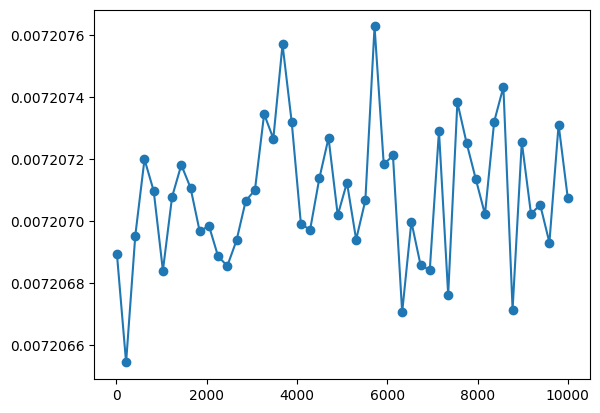

In [18]:
sweep_voltage = np.linspace(0.1, 0.5, 50)  
sweep_frequency = np.linspace(10, 10e3, 50)
DEMOD = 0
R = []
for i in range(len(sweep_frequency)):
    setup = basic_mfli_setup(mfli,V_exc=sweep_frequency[i]*np.sqrt(2),frequency=1e3)
    time.sleep(0.1)  # Allow time for settings to stabilize
    result = mfli.demods[DEMOD].sample() 
    R.append(np.sqrt(result['x']**2 + result['y']**2))

plt.plot(sweep_frequency, np.array(R), marker='o')
